In [107]:
import pandas as pd
from collections import defaultdict
from numpy import nan, mean, log1p, exp, expm1, std
from statistics import mode

from warnings import simplefilter
from IPython import display
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

# Home Data pipeline

See [readme](../README.md) 2do section for next steps

In [108]:
# load data

global column_types, test_data, train_data, full_data
def load_data():
    global column_types, test_data, train_data, full_data
    column_types = defaultdict(lambda: None)
    test_data = pd.read_csv("./test.csv")
    train_data = pd.read_csv("./train.csv")
    full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

load_data()
full_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

In [109]:
# define different data transformation functions

is_nan = lambda x: x != x
equals = lambda a, b: (is_nan(a) and is_nan(b)) or a == b
all_unique_values = lambda column_name: set(full_data[column_name].unique())
all_non_nan_values = lambda column_name: set(full_data[column_name].unique())

def drop(column_name="", data_set=None, ignore_errors=False, **_):
    data_set.drop(column_name, axis=1, inplace=True, errors="ignore" if ignore_errors else "raise")
    return dict(data_set=data_set)

def one_hot(column_name="", data_set=None, options={}, drop=True, **_):
    keys = options if options else set(data_set[column_name].unique())
    for key in keys:
        column_types[f"{column_name}_{key}"] = "categorical"
        data_set[f"{column_name}_{key}"] = data_set[column_name].apply(lambda x: 1 if equals(x, key) else 0)
    if drop:
        data_set.drop(column_name, axis=1, inplace=True)
    return dict(data_set=data_set, kwargs=dict(options=keys, drop=drop))

def apply(fn, column_name="", data_set=None, **_):
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)

def re_map(mapping, column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set[column_name].apply(lambda x: mapping[x] if type(mapping) == dict else mapping(x))
    return dict(data_set=data_set)

def impute(fn=mode, column_name="", data_set=None, imputation=None, **_):
    imputation = fn(data_set[column_name]) if imputation is None else imputation
    data_set[column_name] = data_set[column_name].apply(lambda x: imputation if is_nan(x) else x)
    return dict(data_set=data_set, kwargs=dict(imputation=imputation))

def do_nothing(column_name="", data_set=None, **_):
    return dict(data_set=data_set)

def MSZoning(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C (all)"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return dict(data_set=drop(column_name, data_set)["data_set"])
def MSZoningOld(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        if key == "C":
            continue
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return dict(data_set=drop(column_name, data_set)["data_set"])

def neighborhood_median(column_name="", data_set=None, neighborhood_medians=None, **_):
    column_types[column_name] = "ordinal"
    neighborhood_medians = neighborhood_medians or data_set[[column_name, "Neighborhood"]].groupby("Neighborhood").median().to_dict()[column_name]
    fn = lambda x: neighborhood_medians[x["Neighborhood"]] if is_nan(x[column_name]) else x[column_name]
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set, kwargs=dict(neighborhood_medians=neighborhood_medians))

def PoolQC_erik(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return x["OverallQual"]/2
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)
def PoolQC(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return 1 + (x["OverallQual"]-1)*3/9
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)

def masonry(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                value = data_set["MasVnrArea"].iloc[id]
                # ideally set the above set to the average of that type in that neighborhood (instead of the guess of 75)
                data_set[f"masonry {options[key]} sqft"].iat[id] = value if value > 2 else 75
    
    data_set[f"masonry other sqft"] = 0
    for id in range(len(data_set)):
        if is_nan(data_set["MasVnrType"].iloc[id]) and data_set["MasVnrArea"].iloc[id] > 2:
            data_set["masonry other sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return dict(data_set=data_set)
def masonry_old(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                data_set[f"masonry {options[key]} sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return dict(data_set=data_set)

def fix_basement(column_name="", data_set=None, modes=None):
    basement_fields = [b for b in test_data.keys() if "Bsmt" in b]
    modes = modes or {key: mode(data_set[key].dropna()) for key in basement_fields}
    for row_id, row in data_set[basement_fields].iterrows():
        any_nulls = row.isnull().any()
        non_nulls = [type(i) == str for i in row]
        non_zeros = [i > 0 if type(i) in [float, int] else False for key, i in row.items()]
        if any_nulls and (any(non_nulls) or any(non_zeros)):
            for key, i in row.items():
                if is_nan(i):
                    data_set.at[row_id, key] = modes[key]
    return dict(data_set=data_set, kwargs=dict(modes=modes))

def basement(column_name="", data_set=None, **_):
    # this function disregards pre-split mode imputation and may give incorrect RMSE score
    data_set = fix_basement(data_set=data_set)["data_set"]
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return dict(data_set=data_set)
def basement_old(column_name="", data_set=None, **_):
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return dict(data_set=data_set)

def basement_unfinished(column_name="", data_set=None, **_):
    unf1 = "basement Unfinished sqft"
    unf2 = "BsmtUnfSF"
    data_set[unf1] = data_set.apply(lambda x: x[unf1] + x[unf2], axis=1)
    
    data_set.drop(["BsmtUnfSF"], axis=1, inplace=True)
    return dict(data_set=data_set)

def garage_year(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return dict(data_set=data_set)
def garage_year_old(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearRemodAdd"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return dict(data_set=data_set)

def NA_to_zero(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: 0 if is_nan(x) else x)
    return dict(data_set=data_set)

def condition12(column_name="", data_set=None, **_):
    conditions = dict(
        Artery="Adjacent to arterial street",
        Feedr="Adjacent to feeder street",
        Norm="Normal",
        RRNn="Within 200' of North-South Railroad",
        RRAn="Adjacent to railroad",
        PosN="Near positive off-site feature",
        PosA="Adjacent to positive off-site feature",
        RRNe="Within 200' of East-West Railroad",
        RRAe="Adjacent to East-West Railroad",
    )
    for condition, label in conditions.items():
        data_set[label] = data_set.apply(lambda x: 1 if condition in [x["Condition1"], x["Condition2"]] else 0, axis=1)
        column_types[label] = "categorical"
    data_set.drop(["Condition1", "Condition2"], axis=1, inplace=True)
    return dict(data_set=data_set)

def is_new(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YrSold"] == x["YearBuilt"] else 0, axis=1)
    return dict(data_set=data_set)

def age(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set.apply(lambda x: x["YrSold"] - x["YearRemodAdd"], axis=1)
    return dict(data_set=data_set)

def remodeled(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YearBuilt"] != x["YearRemodAdd"] else 0, axis=1)
    return dict(data_set=data_set)

hoods = train_data[["SalePrice", "Neighborhood"]].groupby("Neighborhood").mean().sort_values("SalePrice").index.tolist()
def hood_check(i):
    if i < 3:
        return 0
    if i >= len(train_data["Neighborhood"].unique()) - 3:
        return 2
    return 1
bougieness = {hood: hood_check(i) for i, hood in enumerate(hoods)}

def scale(column_name="", data_set=None, u=None, s=None, **_):
    s = data_set[column_name].std() if s is None else s
    u = data_set[column_name].mean() if u is None else u
    if is_nan(u) or is_nan(s):
        raise ValueError(f"Mean or standard deviation for '{column_name}' is NaN")
    data_set[column_name] = (data_set[column_name] - u) / s
    return dict(data_set=data_set, kwargs=dict(u=u, s=s))

import inflation
def sale_price(column_name="", data_set=None, **_):
    if column_name in data_set:
        data_set[column_name] = data_set.apply(lambda x: inflation.adjust(
                price = x[column_name],
                from_year = x["YrSold"],
                from_month = x["MoSold"],
                to_year = 2010,
                to_month = 7,
            ), axis=1)
    data_set.drop(["MoSold", "YrSold"], axis=1, inplace=True)
    return dict(data_set=data_set)

def post_sale_price(results, data_set):
    # global original_data
    output = []
    for id, price in enumerate(results):
        id_original = data_set["Id"].iloc[id]
        new_price = inflation.adjust(
            price=price,
            from_year=2010,
            from_month=7,
            to_year=int(full_data["YrSold"][full_data["Id"] == id_original].iloc[0]),
            to_month=int(full_data["MoSold"][full_data["Id"] == id_original].iloc[0]),
        )
        output.append(new_price)
    return results

from scipy.stats import johnsonsu
johnsonsu_fit_params = (-1.5661332502814722, 1.4899652685226785, 93994.93460253121, 55321.66007635476) # a, b, loc, scale
def price_johnson_deskew(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: johnsonsu.cdf(x, *johnsonsu_fit_params))
    return dict(data_set=data_set)

def price_johnson_reskew(results, _):
    de_skewed = johnsonsu.ppf(results, *johnsonsu_fit_params)
    return [min(train_data["SalePrice"]) if is_nan(x) else abs(x) for x in de_skewed]

def normal_deskew(column_name="", data_set=None, **_):
    data_set[column_name] = log1p(data_set[column_name])
    return dict(data_set=data_set)

def normal_reskew(results, _):
    return expm1(results)

def garage_fix(data_set=None, **_):
    if len(data_set[data_set["Id"] == 2127].index):
        id = data_set[data_set["Id"] == 2127].index[0]
        for col in ["GarageFinish", "GarageQual", "GarageCond"]:
            data_set[col].iat[id] = mode(full_data[col])

    if len(data_set[data_set["Id"] == 2577].index):
        id = data_set[data_set["Id"] == 2577].index[0]
        data_set["GarageType"].iat[id] = nan
        data_set["GarageArea"].iat[id] = 0
    return dict(data_set=data_set)

def drop_outliers(data_set=None, **_):
    for Id in [524, 1299]:
        if len(data_set[data_set["Id"] == Id].index):
            id = data_set[data_set["Id"] == Id].index[0]
            data_set = data_set.drop(id).reset_index(drop=True)
    return dict(data_set=data_set)

class Transformation:
    def __init__(self,
            column_name=None,
            data_set=None,
            function=None, # required
            args=[],
            kwargs={},
            #metadata
            pre_fit=True, post_fit=False, description="",
        ):
        assert(function)
        self._transformation = dict(column_name=column_name, data_set=data_set, function=function, args=args, kwargs=kwargs)
        self._metadata = dict(pre_fit=pre_fit, post_fit=post_fit, description=description)

    def __getitem__(self, key):
        return (self._transformation | self._metadata)[key]
    
def transform_data(data_set=train_data, transformations=[], kwargs=[], pre_fit=False, post_fit=False, reference_data=train_data):
    data = data_set.copy()
    kwargs = kwargs or [t["kwargs"] for t in transformations]
    output_kwargs = []
    assert(len(transformations) == len(kwargs))
    for transformation, kwarg in zip(transformations, kwargs):
        # print(transformation["column_name"], transformation["function"], transformation["args"])
        output_kwargs.append(kwarg)
        if transformation["pre_fit"] and pre_fit:
            result = transformation["function"](*transformation["args"], data_set=data, column_name=transformation["column_name"], **kwarg)
            data = result["data_set"]
            if "kwargs" in result:
                output_kwargs[-1] = result["kwargs"]
        if transformation["post_fit"] and post_fit:
            data = transformation["function"](data_set, reference_data)
    return dict(data_set=data, kwargs=output_kwargs)

In [110]:
# specify each column transformation

og_transformations = [
    Transformation(column_name="MSSubClass", function=drop),
    Transformation(column_name="MSZoning", function=MSZoningOld),
    Transformation(column_name="LotFrontage", function=apply, args=[lambda x: 0 if is_nan(x["LotFrontage"]) else x["LotFrontage"]]),
    Transformation(column_name="LandContour", function=re_map, args=[{"Lvl": 1, "Bnk": 3, "HLS": 2, "Low": 0}]),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 0, "Mod": 1, "Sev": 2}]),
    Transformation(column_name="Neighborhood", function=one_hot),
    Transformation(column_name="Condition1", function=drop),
    Transformation(column_name="Condition2", function=drop),
    Transformation(column_name="MasVnrType", function=masonry_old),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 110, "Gd": 95, "TA": 85, "Fa": 75, "Po": 60, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=drop),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 3, "Av": 2, "Mn": 1, "No": 0, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement_old),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 3}]),
    Transformation(column_name="GarageType", function=one_hot),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 2, "RFn": 1, "Unf": 0, "NA": 1, nan: 1}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="PoolQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 2, "Fa": 1, nan: 3}]),
    Transformation(column_name="GarageYrBlt", function=garage_year_old),
    Transformation(column_name="SalePrice", function=sale_price),
    Transformation(function=post_sale_price, pre_fit=False, post_fit=True),
]

new_transformations = [
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=MSZoning),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name="Conditions", function=condition12),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="MasVnrType", function=masonry),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement),
    Transformation(column_name="FullBath", function=NA_to_zero),
    Transformation(column_name="HalfBath", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="bathz", function=apply, args=[lambda x: x["BsmtFullBath"] + x["FullBath"] + 0.5*(x["BsmtHalfBath"] + x["HalfBath"])]),
    Transformation(column_name=["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"], function=drop),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(function=garage_fix, description="fix inconsistent garage values"),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageYrBlt", function=garage_year),
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="PoolQC", function=PoolQC),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="Remodeled", function=remodeled),
    Transformation(column_name="YearRemodAdd", function=drop),
    Transformation(column_name="TotalSqft", function=apply, args=[lambda x: x["TotalBsmtSF"] + x["GrLivArea"]]),
    Transformation(column_name="TotalBsmtSF", function=drop),
    # Transformation(column_name="GarageArea", function=drop, description="correlates strongly with GarageCars (which correlates better with SalePrice)"),
    # Transformation(column_name="TotRmsAbvGrd", function=drop, description="correlates strongly with GrLivArea (which correlates better with SalePrice)"),
    # Transformation(column_name="Age", function=drop, description="correlates strongly with GarageYrBlt (which correlates better with SalePrice)"),
    # Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
]

shared_transformations = [
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="Alley", function=drop),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="Exterior1st", function=one_hot),
    Transformation(column_name="Exterior2nd", function=drop),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="BsmtUnfSF", function=basement_unfinished),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="Electrical", function=re_map, args=[{"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0, nan: 0}]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, nan: 0}]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, nan: 7}]),
    Transformation(column_name="GarageCars", function=NA_to_zero),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="MiscFeature", function=drop),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="YearBuilt", function=drop),
]

erik_bruin = [
    Transformation(column_name="PoolQC", function=PoolQC_erik),
    Transformation(column_name="MiscFeature", function=one_hot),
    Transformation(column_name="Alley", function=re_map, args=[{"Grvl": "None", "Pave": "Pave", nan: "None"}]),
    Transformation(column_name="Alley", function=one_hot),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}]),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="GarageYrBlt", function=apply, args=[lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"]]),
    Transformation(function=garage_fix, description="fix inconsistent garage values (house ID's 2127 & 2577)"), # ignoring pre-split mode computation
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(function=fix_basement),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, nan: 0}]),
    Transformation(column_name="BsmtFinType1", function=re_map, args=[{"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="BsmtFinType2", function=re_map, args=[{"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="BsmtFinSF1", function=NA_to_zero),
    Transformation(column_name="BsmtFinSF2", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="MasVnrType", function=apply, args=[lambda x: mode(full_data["MasVnrType"].dropna()) if x["Id"] == 2611 else x["MasVnrType"]]), # ignoring pre-split mode computation
    Transformation(column_name="MasVnrType", function=re_map, args=[{"Stone": 2, "BrkFace": 1, "BrkCmn": 0, nan: 0}]),
    Transformation(column_name="MasVnrArea", function=NA_to_zero),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=one_hot),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}]),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="Exterior1st", function=one_hot),
    Transformation(column_name="Exterior2nd", function=impute, args=[mode]),
    Transformation(column_name="Exterior2nd", function=one_hot),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="Electrical", function=impute, args=[mode]),
    Transformation(column_name="Electrical", function=one_hot),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Neighborhood", function=one_hot, kwargs={"drop": False}),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="Remodeled", function=remodeled),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name="Condition1", function=one_hot),
    Transformation(column_name="Condition2", function=one_hot),
    Transformation(column_name="TotalSqft", function=apply, args=[lambda x: x["TotalBsmtSF"] + x["GrLivArea"]]),
    Transformation(column_name="FullBath", function=NA_to_zero),
    Transformation(column_name="HalfBath", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotBathrooms", function=apply, args=[lambda x: x["BsmtFullBath"] + x["FullBath"] + 0.5*(x["BsmtHalfBath"] + x["HalfBath"])]),
    Transformation(column_name=['YearRemodAdd', 'GarageYrBlt', 'BsmtFinSF1', "TotalBsmtSF", "GarageArea", "GarageCond"], function=drop),
    Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
    Transformation(
        column_name=['LotConfig_FR3', 'Condition1_PosA', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_Stone', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Grav', 'Heating_Wall', 'Electrical_FuseP', 'GarageType_CarPort', 'MiscFeature_Othr', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleCondition_AdjLand', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'MiscFeature_TenC', 'Electrical_Mix', 'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Membran', 'Exterior2nd_Other', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'MSSubClass_40', 'MSSubClass_150', "Neighborhood_Blueste", "Neighborhood_NPkVill"],
        # Erik's names: ["LotConfigFR3", "Condition1PosA", "Condition1RRNe", "Condition1RRNn", "Condition2Feedr", "Condition2PosA", "Condition2PosN", "RoofStyleMansard", "RoofStyleShed", "RoofMatlWdShake", "RoofMatlWdShngl", "Exterior1stAsphShn", "Exterior1stBrkComm", "Exterior1stCBlock", "Exterior2ndAsphShn", "Exterior2ndBrk Cmn", "Exterior2ndCBlock", "Exterior2ndStone", "FoundationStone", "FoundationWood", "HeatingGrav", "HeatingWall", "ElectricalFuseP", "GarageTypeCarPort", "MiscFeatureOthr", "SaleTypeCon", "SaleTypeConLD", "SaleTypeConLI", "SaleTypeConLw", "SaleTypeCWD", "SaleTypeOth", "SaleConditionAdjLand", "Condition2RRAe", "Condition2RRAn", "Condition2RRNn", "HouseStyle2.5Fin", "RoofMatlMembran", "RoofMatlMetal", "RoofMatlRoll", "Exterior1stImStucc", "Exterior1stStone", "Exterior2ndOther", "HeatingOthW", "ElectricalMix", "MiscFeatureTenC", "MSSubClass1,5 story PUD all", "MSSubClass1 story unf attic"],
        function=drop,
        kwargs=dict(ignore_errors=True),
    ),
    Transformation(column_name="PorchSqft", function=apply, args=[lambda x: x["OpenPorchSF"] + x["EnclosedPorch"] + x["3SsnPorch"] + x["ScreenPorch"]]),
    Transformation(
        column_name=["BldgType_1Fam", "Condition1_Artery", "Exterior1st_AsbShng", "Exterior2nd_AsbShng", "Condition2_Artery", "Electrical_FuseA", "Fence_GdPrv", "Foundation_BrkTil", "GarageType_2Types", "Heating_Floor", "HouseStyle_1.5Fin", "LandContour_Bnk", "LotConfig_Corner", "MiscFeature_Gar2", "MoSold_1", "MSSubClass_20", "MSZoning_C (all)", "Neighborhood_Blmngtn", "RoofMatl_ClyTile", "RoofStyle_Flat", "SaleCondition_Abnorml", "SaleType_COD", "YrSold_2006"],
        # Erik's factorization method removes these - it's probably not necessary... maybe improves performance... but then why not just use binary encoding & remove even more columns
        function=drop,
    ),
]

transformation_schemes = [
    {
        "name": "new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
        ],
    },
    {
        "name": "johnsonsu+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
            Transformation(column_name="SalePrice", function=price_johnson_deskew),
            Transformation(function=price_johnson_reskew, pre_fit=False, post_fit=True),
        ],
    },
    {
        "name": "normalize+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
            Transformation(column_name="SalePrice", function=normal_deskew),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
    },
    {"name": "og (without hack)", "transformations": og_transformations + shared_transformations},
]

column_types["bathz"] = "ordinal"

In [111]:
# transformations = erik_bruin
# td = transform_data(transformations=transformations, data_set=train_data, pre_fit=True)
# list(td.columns)
from statistics import stdev, mean
import numpy as np
from sklearn.preprocessing import StandardScaler

s = np.std(train_data["SalePrice"], ddof=0)
u = mean(train_data["SalePrice"])
z0 = (train_data["SalePrice"] - u) / s

# from sklearn.preprocessing import scale
# z1 = scale(train_data["SalePrice"])

scaler = StandardScaler()
scaler.fit(train_data["SalePrice"].values.reshape(-1, 1))
z2 = scaler.transform([[x] for x in train_data["SalePrice"].values])
print(z0)
print(z2)


0       0.347273
1       0.007288
2       0.536154
3      -0.515281
4       0.869843
          ...   
1455   -0.074560
1456    0.366161
1457    1.077611
1458   -0.488523
1459   -0.420841
Name: SalePrice, Length: 1460, dtype: float64
[[ 0.34727322]
 [ 0.00728832]
 [ 0.53615372]
 ...
 [ 1.07761115]
 [-0.48852299]
 [-0.42084081]]


# find correlated variables for dropping

In [112]:
transformed_data = transform_data(transformations=erik_bruin, data_set=full_data, pre_fit=True)["data_set"]

corr = None
corr = transformed_data[transformed_data["SalePrice"].notna()].copy()
corr = corr.corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = transformed_data.copy()
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

In [113]:
both_corr

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SalePrice,MiscFeature_nan,MiscFeature_Shed,Alley_None,Alley_Pave,Fence_MnPrv,Fence_nan,Fence_MnWw,Fence_GdWo,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,GarageType_Detchd,GarageType_Attchd,GarageType_nan,GarageType_Basment,GarageType_BuiltIn,MSZoning_RL,MSZoning_RH,MSZoning_FV,MSZoning_RM,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_BrkFace,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_HdBoard,Exterior1st_CemntBd,Exterior1st_Stucco,Exterior1st_Plywood,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_BrkFace,Exterior2nd_HdBoard,Exterior2nd_CmentBd,Exterior2nd_Stucco,Exterior2nd_Plywood,Exterior2nd_Wd Shng,Electrical_SBrkr,Electrical_FuseF,SaleType_New,SaleType_WD,SaleCondition_Alloca,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Normal,Foundation_CBlock,Foundation_Slab,Foundation_PConc,Heating_GasW,Heating_GasA,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofMatl_Tar&Grv,RoofMatl_CompShg,LandContour_Low,LandContour_HLS,LandContour_Lvl,BldgType_Duplex,BldgType_2fmCon,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_1Story,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2Story,Neighborhood_NAmes,Neighborhood_Mitchel,Neighborhood_SawyerW,Neighborhood_NridgHt,Neighborhood_Edwards,Neighborhood_NWAmes,Neighborhood_IDOTRR,Neighborhood_Somerst,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_BrkSide,Neighborhood_OldTown,Neighborhood_MeadowV,Neighborhood_Crawfor,Neighborhood_SWISU,Neighborhood_Gilbert,Neighborhood_ClearCr,Neighborhood_Sawyer,Neighborhood_NoRidge,Neighborhood_Timber,Neighborhood_StoneBr,Neighborhood_BrDale,Age,IsNew,Remodeled,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,MSSubClass_160,MSSubClass_70,MSSubClass_75,MSSubClass_45,MSSubClass_80,MSSubClass_50,MSSubClass_85,MSSubClass_180,MSSubClass_30,MSSubClass_120,MSSubClass_90,MSSubClass_60,MSSubClass_190,Condition1_Feedr,Condition1_RRAn,Condition1_PosN,Condition1_Norm,Condition1_RRAe,Condition2_Norm,TotalSqft,TotBathrooms,PorchSqft
Id,1.000000,-0.030577,-0.015126,0.002989,0.014631,0.018623,-0.041234,-0.031681,0.002195,-0.014769,-0.024673,-0.029271,-0.013168,0.003110,-0.028980,-0.028602,0.014140,-0.019649,-0.000845,0.005794,-0.014760,-0.003210,-0.013936,-0.012108,-0.019471,-0.038146,-0.030608,-0.001421,0.008409,-0.012886,-0.014879,-0.002778,-0.008082,-0.014802,-0.029467,-0.016886,-0.038324,-0.035673,-0.007563,-0.016799,-0.036886,-0.046944,-0.015300,0.003761,0.034850,-0.044198,0.034866,0.021800,0.021795,-0.017070,-0.018362,0.019637,-0.023268,0.014216,-0.014216,0.014914,-0.007012,-0.046177,0.000962,-0.011240,-0.018989,0.031594,0.005184,-0.014121,-0.003175,0.003846,0.004657,-0.009773,-0.020129,-0.011566,0.018496,0.010454,-0.016375,-0.008618,-0.001634,0.005127,-0.000445,0.017181,-0.019234,0.004237,-0.021316,0.015813,-0.010944,-0.000433,0.005950,-0.006431,0.021994,-0.007996,-0.005160,0.008935,0.005281,-0.007666,0.024259,-0.021627,-0.007103,0.023766,0.014437,-0.020530,-0.012902,0.013663,-0.005146,-0.032926,0.037087,0.014425,-0.007351,-0.006019,0.007342,0.022747,-0.022172,0.044574,-0.015104,0.011649,0.001087,-0.003778,0.013589,0.001181,-0.047426,0.034963,0.009036,0.010668,-0.017778,-0.007419,0.039569,-0.012264,-0.020647,0.019068,-0.022026,0.040719,-0.004487,-0.010430,-0.004169,-0.019094,0.002592,0.025135,0.023505,0.006839,-0.009180,-0.040369,0.0

In [114]:
indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")
high_corr

,SalePrice,TotalSqft,OverallQual,GrLivArea,TotBathrooms,GarageCars,ExterQual,BsmtQual,KitchenQual,YearBuilt,FullBath,GarageFinish,Age,1stFlrSF,Foundation_PConc,FireplaceQu,TotRmsAbvGrd,Fireplaces,Neighborhood
SalePrice,1.000000,0.816229,0.811082,0.732342,0.704772,0.690974,0.685228,0.678946,0.673825,0.653422,0.636262,0.634542,-0.577166,0.576221,0.562402,0.538008,0.533253,0.519924,0.514287
TotalSqft,0.816229,1.000000,0.654234,0.868517,0.609112,0.572367,0.521828,0.505683,0.494395,0.406381,0.615303,0.455459,-0.353676,0.752755,0.380222,0.501104,0.675140,0.492398,0.452237
OverallQual,0.811082,0.654234,1.000000,0.601593,0.555587,0.608172,0.714634,0.671634,0.658996,0.646007,0.575117,0.565757,-0.561645,0.406240,0.585815,0.479609,0.425405,0.418912,0.466004
GrLivArea,0.732342,0.868517,0.601593,1.000000,0.602862,0.504199,0.443834,0.385682,0.425305,0.285742,0.657463,0.386046,-0.287751,0.492338,0.330677,0.479022,0.827155,0.479319,0.364047
TotBathrooms,0.704772,0.609112,0.555587,0.602862,1.000000,0.528603,0.492265,0.560868,0.484891,0.551463,0.705343,0.494228,-0.413250,0.356119,0.444825,0.309060,0.450927,0.342663,0.352631
GarageCars,0.690974,0.572367,0.608172,0.504199,0.528603,1.000000,0.541682,0.551085,0.519434,0.600983,0.517204,0.547698,-0.461921,0.449512,0.479498,0.356140,0.384968,0.325013,0.432826
ExterQual,0.685228,0.521828,0.714634,0.443834,0.492265,0.541682,1.000000,0.644063,0.723933,0.677640,0.507007,0.534532,-0.631731,0.334301,0.631888,0.349838,0.296770,0.259884,0.461454
BsmtQual,0.678946,0.505683,0.671634,0.385682,0.560868,0.551085,0.644063,1.000000,0.573225,0.773531,0.509327,0.554111,-0.590090,0.298486,0.662914,0.314807,0.221450,0.260197,0.389163
KitchenQual,0.673825,0.494395,0.658996,0.425305,0.484891,0.519434,0.723933,0.573225,1.000000,0.596083,0.459729,0.478747,-0.658004,0.338098,0.566647,0.346115,0.282274,0.262172,0.405060
YearBuilt,0.653422,0.406381,0.646007,0.285742,0.551463,0.600983,0.677640,0.773531,0.596083,1.000000,0.536187,0.619278,-0.688838,0.290615,0.703397,0.234537,0.173628,0.172263,0.375454


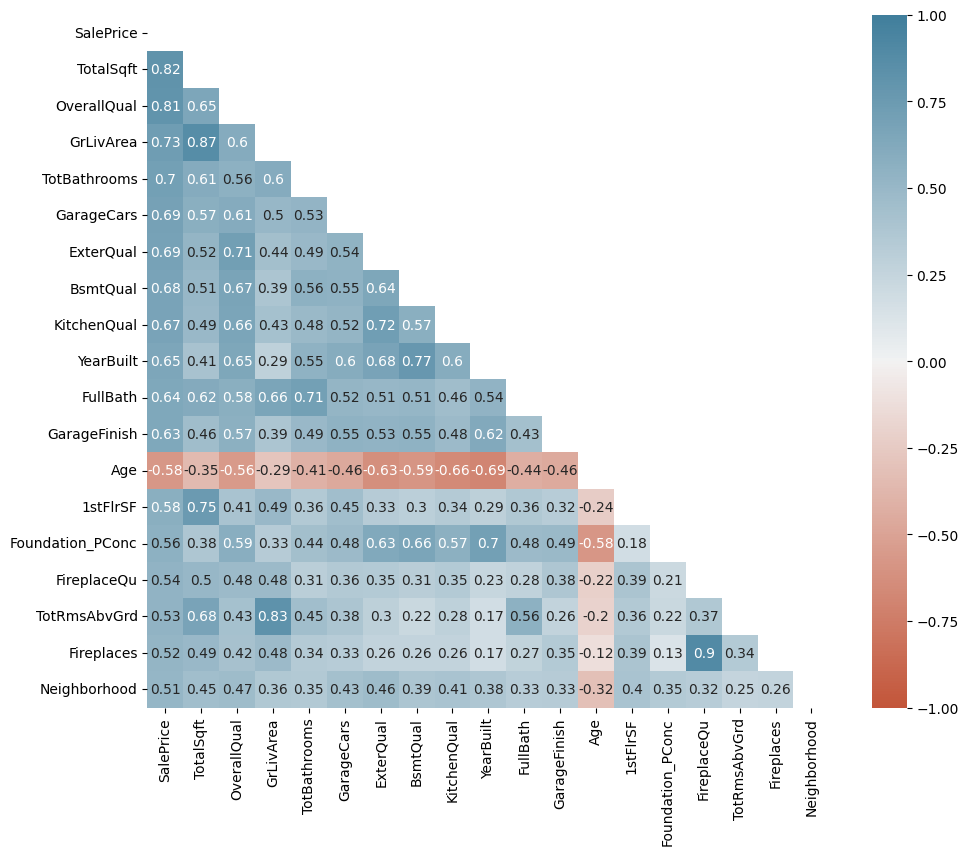

In [115]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

In [116]:
output = pd.DataFrame(columns=["column1 (& type)", "column2 (& type)", "correlation"])

correlations = dict()
for col1, item in dict(both_corr).items():
    for col2, value in dict(item).items():
        if col1 == col2:
            continue
        key1, key2 = sorted([col1, col2])
        correlations[(key1, key2)] = value

correlations = sorted(correlations.items(), reverse=True, key=lambda x: abs(x[1]))
limit = 20
n = 0
for (key1, key2), value in correlations:
    if n >= limit:
        break
    if "categorical" in [column_types[key1], column_types[key2]]:
        continue
    output.loc[n] = [f"{key1} ({column_types[key1] or 'numeric'})", f"{key2} ({column_types[key2] or 'numeric'})", value]
    n += 1
output

,column1 (& type),column2 (& type),correlation
0,PoolArea (numeric),PoolQC (ordinal),0.999993
1,MasVnrArea (numeric),MasVnrType (ordinal),0.917880
2,BsmtFinSF2 (numeric),BsmtFinType2 (ordinal),0.907827
3,FireplaceQu (ordinal),Fireplaces (numeric),0.903935
4,GrLivArea (numeric),TotalSqft (numeric),0.862384
5,SalePrice (numeric),TotalSqft (numeric),0.816229
6,OverallQual (numeric),SalePrice (numeric),0.811082
7,GrLivArea (numeric),TotRmsAbvGrd (numeric),0.808375
8,BsmtQual (ordinal),YearBuilt (numeric),0.786145
9,1stFlrSF (numeric),TotalSqft (numeric),0.751192


In [117]:
drop_correlated_columns = [
    "MSSubClass_90", # correlates exactly with BldgType_Duplex
    "GarageArea", # correlates strongly with GarageCars (which correlates better with SalePrice)
    "TotRmsAbvGrd", # correlates strongly with GrLivArea (which correlates better with SalePrice)
    # "Age", # correlates strongly with GarageYrBlt (which correlates better with SalePrice)
]

# De-skew, center, and scale numeric columns

In [118]:
from sigfig import round
verbose = False
do_de_skew = set(["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF2", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtHalfBath", "KitchenAbvGr", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "TotalSqft", "PorchSqft"])
dont_de_skew = set(["YearBuilt", "BsmtFullBath", "FullBath", "HalfBath", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "TotBathrooms", "Age"])
all_numeric_from_erik = do_de_skew | dont_de_skew

output = []
for col in transformed_data.columns:
    skew = transformed_data[col].skew()
    agreement = (abs(skew) > 0.8 and col in do_de_skew) or (abs(skew) <= 0.8 and col not in do_de_skew)
    output.append(dict(column=col, type=column_types[col] or "numeric", skew=skew, agree="👍" if agreement else "🙅‍♀️", seven=7))
output = sorted(output, key=lambda x: abs(x["skew"]), reverse=True)
output = pd.DataFrame(output)
indicies = set(output[output["type"] == "numeric"].index) | set(output[output["column"].isin(do_de_skew)].index) | set(output[output["column"].isin(dont_de_skew)].index)
output = output.iloc[sorted([i for i in indicies])].reset_index(drop=True)
with pd.option_context("display.max_rows", None):
    if verbose:
        display.display(output)
        print("missing columns from Erik", all_numeric_from_erik - set(transformed_data.columns))

def roundington(column_name="", data_set=None, decimals=14, **_):
    # fast but inaccurate
    # TODO: add extension to sigfig which greatly improves speed by generating result numerically instead of through string comprehension
    data_set[column_name] = data_set[column_name].round(decimals)
    return dict(data_set=data_set)

integate = [
    Transformation(column_name=col, function=NA_to_zero) for col in all_numeric_from_erik
] + [
    Transformation(column_name=col, function=re_map, args=[lambda x: int(x)]) for col in all_numeric_from_erik - {"TotBathrooms"}
]
de_skew = [Transformation(column_name=col, function=normal_deskew) for col in do_de_skew]
round_em = [Transformation(column_name=col, function=re_map, args=[lambda x: round(x, 15)]) for col in do_de_skew]
# round_em = [Transformation(column_name=[col for col in do_de_skew], function=roundington)]
scale_em = [Transformation(column_name=col, function=scale) for col in all_numeric_from_erik]

numeriks = integate + de_skew + round_em + scale_em
# numeriks = de_skew + round_em + scale_em

# Find sparse data for dropping

In [119]:
transformed_train_data = transformed_data[transformed_data["SalePrice"].notna()].drop("SalePrice", axis=1)
transformed_test_data = transformed_data[transformed_data["SalePrice"].isna()].drop("SalePrice", axis=1)
columns_with_same_val = set([col for col in transformed_data.drop("SalePrice", axis=1).columns if \
    len(transformed_train_data.index) - max(transformed_train_data[col].value_counts()) < 20 or \
    len(transformed_test_data.index) - max(transformed_test_data[col].value_counts()) < 20 \
])

output = pd.DataFrame(columns=["column", "type", "training occurrences", "test occurrences", "mode", "decision", "total"])
drop_saturated_columns = []
for i, col in enumerate(columns_with_same_val):
    non_similar_full = len(transformed_train_data.index) - max(transformed_train_data[col].value_counts())
    non_similar_test = len(transformed_test_data.index) - max(transformed_test_data[col].value_counts())
    # dr0p = non_similar_full == 0 or non_similar_test == 0 or non_similar_full + non_similar_test < 19 and column_types[col] == "categorical"
    dr0p = non_similar_full == 0 or non_similar_test == 0
    popular_value = transformed_train_data[col].value_counts().idxmax()
    output.loc[i+1] = [col, column_types[col], non_similar_full, non_similar_test, popular_value, "🔪" if dr0p else "👍", non_similar_full + non_similar_test]
    if dr0p:
        drop_saturated_columns.append(col)

with pd.option_context('display.max_rows', None):
    display.display(output.sort_values("total").reset_index(drop=True))


,column,type,training occurrences,test occurrences,mode,decision,total
0,PoolQC,ordinal,6,6,0.0,👍,12
1,Fence_MnWw,categorical,11,1,0.0,👍,12
2,Street,ordinal,6,6,1.0,👍,12
3,PoolArea,None,6,6,0.0,👍,12
4,Exterior2nd_ImStucc,categorical,10,5,0.0,👍,15
5,MSSubClass_180,categorical,10,7,0.0,👍,17
6,MSSubClass_45,categorical,12,6,0.0,👍,18
7,HouseStyle_1.5Unf,categorical,14,5,0.0,👍,19
8,RoofStyle_Gambrel,categorical,11,11,0.0,👍,22
9,RoofMatl_Tar&Grv,categorical,11,12,0.0,👍,23


In [120]:
pd.set_option('display.max_rows', 20)
drop_columns = list(set(drop_correlated_columns + drop_saturated_columns))
print(f"dropping the following {len(drop_columns)} columns:")
for col in drop_columns:
    print("  -", col)

transformation_schemes = [
    {
        "name": "Erik Bruin's",
        "transformations": erik_bruin + de_skew + scale_em + [
            Transformation(column_name="SalePrice", function=normal_deskew),
            # Transformation(column_name=drop_columns, function=drop),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "leak_all_data": True,
    },
    {
        "name": "big drop +normalize+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(column_name="SalePrice", function=normal_deskew),
            Transformation(column_name=drop_columns, function=drop, kwargs=dict(ignore_errors=True)),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
    },
] + transformation_schemes

dropping the following 3 columns:
  - GarageArea
  - MSSubClass_90
  - TotRmsAbvGrd


# Fit, cross-validate, & compare

RMSE score using "Erik Bruin's" scheme: $ 0.1299 ± 0.0066 k
RMSE score using "big drop +normalize+new" scheme: $ 0.134 ± 0.016 k
RMSE score using "new" scheme: $ 0.1286 ± 0.0088 k
RMSE score using "johnsonsu+new" scheme: $ 0.150 ± 0.029 k
RMSE score using "normalize+new" scheme: $ 0.128 ± 0.011 k
RMSE score using "og (without hack)" scheme: $ 0.145 ± 0.018 k


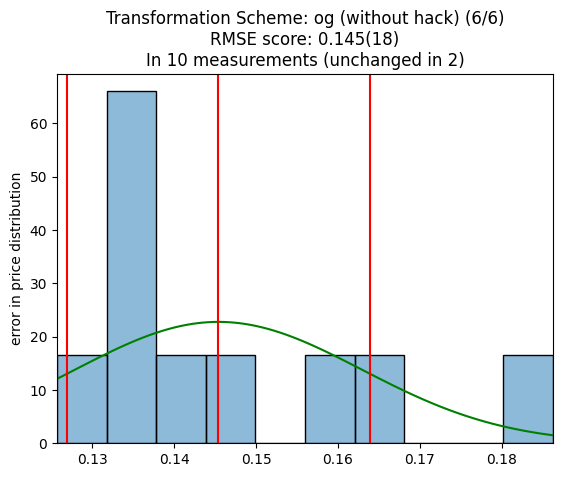

In [121]:
from xgboost import XGBRegressor
from sigfig import round
from sklearn.metrics import root_mean_squared_error
from capture_output import Capturing
from random import shuffle
from numpy import linspace, log10, sqrt
from statistics import stdev as _stdev
from scipy.stats import norm, ks_1samp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

def stdev(data):
    try:
        return _stdev(data)
    except:
        return 0
def price_plot(errors=[], streak=0, label=""):
    base_plot = sns.histplot(pd.DataFrame(errors), legend=False, bins=10, stat='density')

    fit = norm
    x = linspace(*base_plot.get_xlim(), 100)
    y = fit.pdf(x, *fit.fit(errors))
    p = ks_1samp(errors, fit(*fit.fit(errors)).cdf).pvalue
    plt.plot(x, y, color="g", label=f"{fit.name} fit (p≈$10^{{{int(log10(p))}}}$)")

    plt.axvline(x = mean(errors), color = 'r')
    plt.axvline(x = mean(errors) + stdev(errors), color = 'r')
    plt.axvline(x = mean(errors) - stdev(errors), color = 'r')
    title = [
        f"Transformation Scheme: {label}" if label else "",
        f"RMSE score: {round(mean(errors), stdev(errors), format='Drake')}",
        f"In {len(errors)} measurements{f' (unchanged in {streak}' if streak else ''})",
    ]
    base_plot.set_title("\n".join([t for t in title if t]))
    base_plot.set_ylabel('error in price distribution')
    base_plot.set_xlim(min(errors), max(errors))
def update_price_plot(errors, label="", streak_length=None):
    try:
        plt.cla()
        price_plot(errors=errors, streak=streak_length, label=label)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except:
        None

def generate_cross_validation_sets(data=train_data, sets=5):
    ids = data["Id"].to_list()
    shuffle(ids)
    set_size = len(data) // sets
    for n in range(sets):
        yield sorted(ids[n*set_size:(n+1)*set_size])

def split_and_transform_data(data=train_data, test_ids=None, transformations=[], leak_validation_data=False, leak_all_data=False, **_):
    if leak_all_data:
        data = transform_data(data_set=full_data, transformations=transformations, pre_fit=True)["data_set"]
        training_data = data.drop(data[data["Id"].isin(test_ids)].index)
        training_data = training_data[training_data["SalePrice"].notna()]
        training_price = training_data["SalePrice"]
        validation_data = data[data["Id"].isin(test_ids)]
        validation_price = validation_data["SalePrice"]
        return training_data, training_price, validation_data, validation_price
    if leak_validation_data:
        data = transform_data(data_set=train_data, transformations=transformations, pre_fit=True)["data_set"]
        training_data = data.drop(data[data["Id"].isin(test_ids)].index)
        training_price = training_data["SalePrice"]
        validation_data = data[data["Id"].isin(test_ids)]
        validation_price = validation_data["SalePrice"]
        return training_data, training_price, validation_data, validation_price
    
    training_data = data.drop(data[data["Id"].isin(test_ids)].index)
    results = transform_data(
        data_set=training_data,
        transformations=transformations,
        pre_fit=True,
        # TODO: indicate that the test set will be used for validation
    )
    training_data = results["data_set"]
    training_price = training_data["SalePrice"]

    validation_data = data[data["Id"].isin(test_ids)]
    validation_data = transform_data(
        data_set=validation_data,
        transformations=transformations,
        kwargs=results["kwargs"], 
        pre_fit=True,
    )["data_set"]
    validation_price = validation_data["SalePrice"]

    return training_data, training_price, validation_data, validation_price

def cross_validate(test_ids, scheme):
    training_data, training_price, validation_data, validation_price = split_and_transform_data(test_ids=test_ids, **scheme)

    missing_columns = (set(validation_data.columns) - set(training_data.columns) | set(training_data.columns) - set(validation_data.columns)) - set(["SalePrice", "Id"])
    if missing_columns:
        print("the following columns exist in only 1 data set", list(missing_columns))
    training_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')
    validation_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')

    model = None
    model = XGBRegressor(n_estimators=1_000, learning_rate=0.05, early_stopping_rounds=5)
    with Capturing() as output:
        model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_price, eval_set=[(validation_data.drop(["SalePrice", "Id"], axis=1), validation_price)])

    predictions = model.predict(validation_data.drop(["SalePrice", "Id"], axis=1))
    predictions = transform_data(data_set=predictions, transformations=scheme["transformations"], post_fit=True)["data_set"]

    validation_price_original = train_data[train_data["Id"].isin(validation_data["Id"].to_list())]["SalePrice"]
    error = float(root_mean_squared_error(log1p(validation_price_original), log1p(predictions)))

    x = pd.DataFrame({"vpo": validation_price_original, "predict": predictions})
    x["% error"] = (x["vpo"] - x["predict"])/x["vpo"]*100
        
    return {"error": error, "iterations": len(output), "baddies": x["% error"].to_dict()}

def benchmark(scheme, time_limit=timedelta(minutes=15), streak_limit=20, verbose=True, validation_sets=5, label=""):
    streak = {"value": 0, "length": 0}
    start_time = datetime.now()
    errors = []
    baddies = defaultdict(lambda: [])
    while True:
        if streak["length"] > streak_limit:
            break
        time_elapsed = datetime.now() - start_time
        if time_elapsed > time_limit:
            break
        for test_ids in generate_cross_validation_sets(sets=validation_sets):
            results = cross_validate(test_ids, scheme=scheme)
            errors.append(results["error"])
            for key, value in results["baddies"].items():
                baddies[key + 1].append(value)
            cumulative_error = round(mean(errors), stdev(errors), sep=tuple)
            if cumulative_error == streak["value"]:
                streak["length"] += 1
            else:
                streak["value"] = cumulative_error
                streak["length"] = 1

            if verbose:
                update_price_plot(errors, label=label, streak_length=streak["length"])

    return errors, baddies

results = []
badz = []
for id, scheme in enumerate(transformation_schemes):
    label=f"{scheme['name']} ({id + 1}/{len(transformation_schemes)})"
    errors, baddies = benchmark(scheme, label=label, time_limit=timedelta(seconds=15))
    badz.append(baddies)
    result = f"RMSE score using \"{scheme['name']}\" scheme: $ {round(mean(errors), stdev(errors), cutoff=99)} k"
    results.append(result)

for result in results:
    print(result)

In [122]:
# house ID's consistently poorly modeled
def val(item):
    values = [abs(i) for i in item[1]]
    return mean(values)

super_bad = dict()
for bad in badz:
    for key, value in bad.items():
        super_bad[key] = super_bad.get(key, []) + value

output = []
for x in sorted(super_bad.items(), key=val, reverse=True):
    if abs(mean(x[1])) < 40:
        break
    output.append({
        "Id": x[0],
        # "%error": round(mean(x[1]), stdev(x[1]), cutoff=99).ljust(15),
        "%error": int(round(mean(x[1]), stdev(x[1])).split(" ")[0]),
        "+/-": int(round(mean(x[1]), stdev(x[1])).split(" ")[2]),
        "SaleCondition": train_data[train_data["Id"] == x[0]]["SaleCondition"].iloc[0],
    })
baddoz = pd.DataFrame(output)

with pd.option_context('display.max_rows', None):
    display.display(baddoz)
pd.set_option('display.max_rows', 20)

,Id,%error,+/-,SaleCondition
0,524,-190,40,Partial
1,31,-140,20,Normal
2,496,-120,20,Abnorml
3,633,-120,10,Family
4,917,-110,20,Abnorml
5,1325,-100,10,Partial
6,463,-91,6,Normal
7,411,-90,10,Abnorml
8,1299,-80,90,Partial
9,969,-80,40,Abnorml


,Id,%error,+/-,SaleCondition,sort
0,524,-190,40,Partial,186.885721
1,1325,-100,10,Partial,96.143150
2,1299,-80,90,Partial,78.499564
3,582,-50,5,Partial,50.301011
4,589,-50,10,Partial,46.574994
5,689,41,3,Partial,41.174354


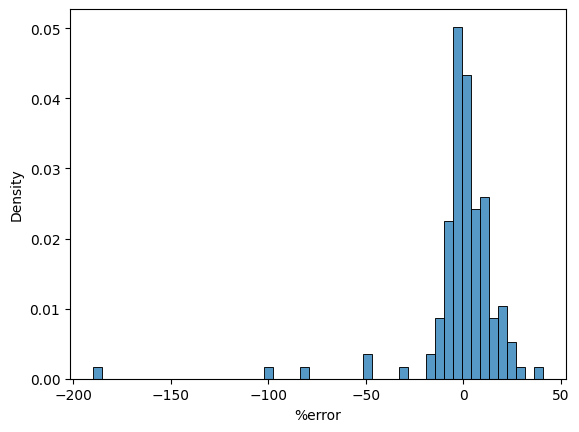

In [123]:
# does partial sale condition have anything to do with it? 🤷‍♂️

output = []
for x in sorted(super_bad.items(), key=val, reverse=True):
    if train_data[train_data["Id"] == x[0]]["SaleCondition"].iloc[0] != "Partial":
        continue
    output.append({
        "Id": str(x[0]),
        # "%error": round(mean(x[1]), stdev(x[1]), cutoff=99).ljust(15),
        "%error": int(round(mean(x[1]), stdev(x[1])).split(" ")[0]),
        "+/-": int(round(mean(x[1]), stdev(x[1])).split(" ")[2]),
        "SaleCondition": train_data[train_data["Id"] == x[0]]["SaleCondition"].iloc[0],
        "sort": abs(mean(x[1])),
    })
output = pd.DataFrame(output)
sns.histplot(output["%error"], bins=50, stat='density')

output[output["sort"] > 30]

# Generate Output

In [124]:
from xgboost import XGBRegressor

train_transformations = erik_bruin + de_skew + scale_em + [
    Transformation(column_name="SalePrice", function=normal_deskew),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]
test_transformations = erik_bruin + de_skew + scale_em + [
    Transformation(function=do_nothing),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]

results = transform_data(
    data_set=train_data,
    transformations=train_transformations,
    pre_fit=True,
)
training_data = results["data_set"]
testing_data = transform_data(
    transformations=test_transformations,
    data_set=test_data,
    kwargs=results["kwargs"],
    pre_fit=True
)["data_set"]

model = None
model = XGBRegressor(n_estimators=1_000, learning_rate=0.05)
model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_data["SalePrice"])
# model.fit(training_data.drop(["SalePrice", "Id"], axis=1), train_data["SalePrice"]) <- use this to replicate OG's accidental success

predictions = model.predict(testing_data.drop("Id", axis=1))
predictions = transform_data(transformations=test_transformations, data_set=predictions, post_fit=True, reference_data=testing_data)["data_set"]

submission = pd.DataFrame({'Id': testing_data.index + 1461, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
submission

,Id,SalePrice
0,1461,117585.960938
1,1462,165769.906250
2,1463,188949.171875
3,1464,193463.562500
4,1465,193716.875000
...,...,...
1454,2915,80011.335938
1455,2916,81193.406250
1456,2917,153611.765625
1457,2918,118529.117188


In [125]:
# manual validation
from itertools import chain
# load_data()
m_fields = [g for g in test_data.keys() if "masonry" in g] + ["Id"]
# for id, row in chain(test_data[garage_fields].iterrows(), full_data[garage_fields].iterrows()):
#     if row.isnull().any():
#         if any([type(i) == str for i in row]) or any([i > 0 if type(i) in [float, int] and key != "Id" else False for key, i in row.items()]):
#             print(row)
Idz = [1670, 2320, 2453, 2611, 625, 689, 774, 1231, 1242, 1301, 1335]
output = pd.DataFrame(columns=full_data.keys())
for s3t in test_data, full_data:
    output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
output[m_fields]
# full_data.drop("Id", axis=1).isnull().values.any()
output = pd.DataFrame(columns=full_data.keys())
for id, row in test_data.iterrows():
    if row.isnull().any():
        output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])
# test_data.isnull().any(axis=1).sum()
output
column_types
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     #get ready to wait 75 seconds
#     display(full_data)
full_data[full_data["Id"].isin([813,939,826])]

/tmp/ipykernel_1030/77202551.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
/tmp/ipykernel_1030/77202551.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
812,813,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,5,5,1952,1952,Hip,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,Fa,TA,CBlock,TA,TA,Av,Unf,0.0,Unf,0.0,540.0,540.0,GasA,TA,N,FuseA,1044,0,0,1044,0.0,0.0,1,0,2,1,Fa,4,Typ,0,NaN,Basment,1952.0,Unf,2.0,504.0,TA,TA,N,0,0,0,0,0,0,NaN,NaN,Shed,54,6,2010,WD,Alloca,55993.0
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1636.0,Unf,0.0,442.0,2078.0,GasA,Ex,Y,SBrkr,2084,0,0,2084,1.0,0.0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.0,Fin,3.0,1220.0,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000.0
938,939,60,RL,73.0,8760,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,Gd,Mn,GLQ,464.0,Unf,0.0,927.0,1391.0,GasA,Ex,Y,SBrkr,1391,571,0,1962,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2006.0,RFn,3.0,868.0,TA,TA,Y,0,90,0,0,0,0,NaN,NaN,NaN,0,8,2006,New,Partial,239799.0


In [126]:
td = transform_data(
    data_set=train_data.drop("SalePrice", axis=1),
    transformations=new_transformations + shared_transformations,
    pre_fit=True,
)["data_set"]
td["%error"] = td.apply(lambda x: mean(super_bad[x["Id"]]), axis=1)

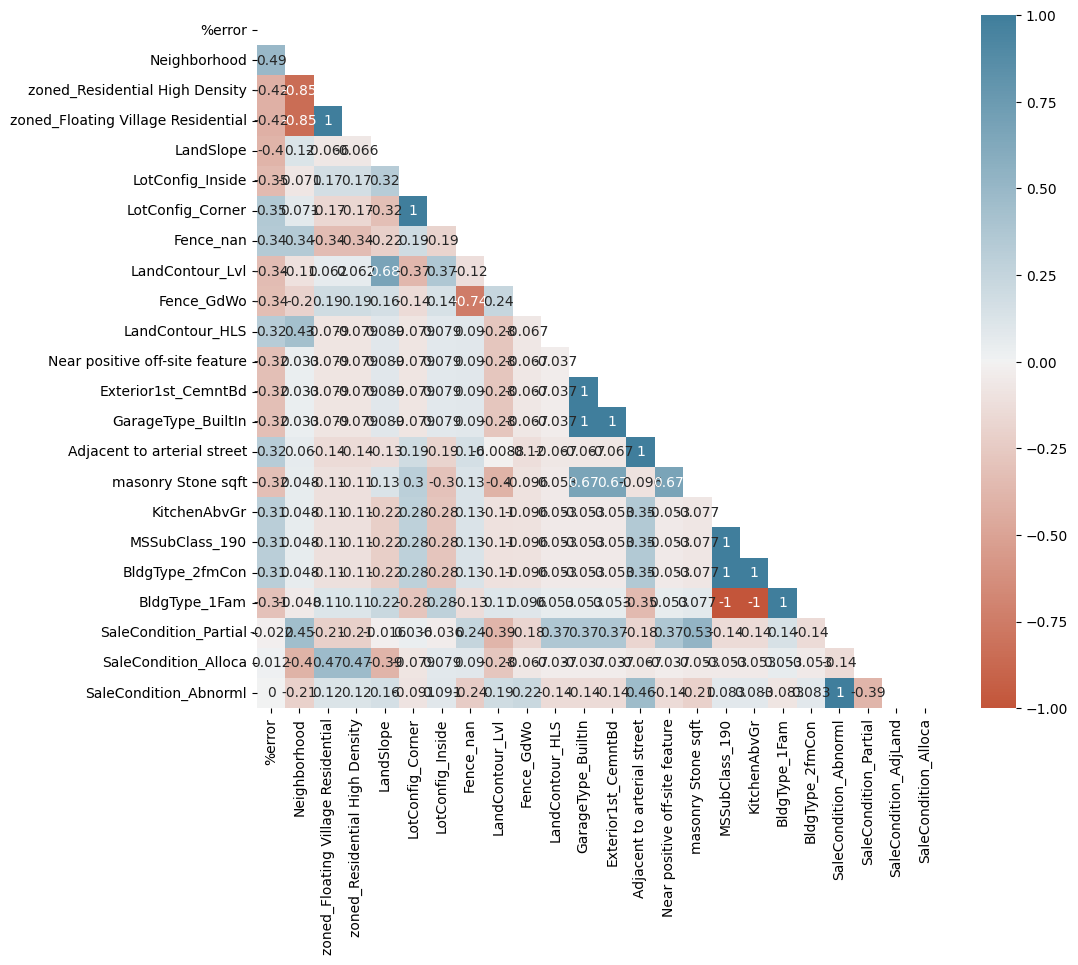

In [127]:
corr = None
corr = td[td["Id"].isin(set(baddoz["Id"]))].corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = td[td["Id"].isin(set(baddoz["Id"]))].copy()
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

strange_conditions = [f"SaleCondition_{c}" for c in ("Abnorml", "Partial", "AdjLand", "Alloca")]
indicies = list(corr["%error"][corr["%error"].abs() > 0.3].sort_values(ascending=False, key=abs).index) + strange_conditions
high_corr = corr[indicies][corr.index.isin(indicies)].sort_values(ascending=False, key=abs, by="%error")

high_corr

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

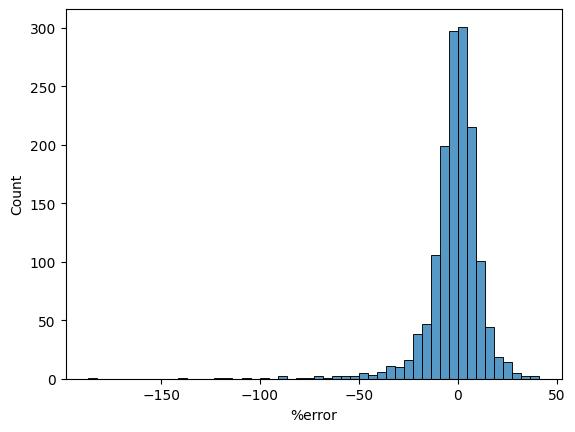

In [128]:
sns.histplot(td["%error"], legend=False, bins=50)
None

In [129]:
# transformations = erik_bruin + integate + de_skew + round_em + [
transformations = erik_bruin + numeriks + [
    Transformation(column_name="SalePrice", function=normal_deskew),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]
td = transform_data(
    data_set=full_data,
    transformations=transformations,
    pre_fit=True,
)["data_set"]

# td["LotFrontage"] = td["LotFrontage"].apply(lambda x: round(x, 15))

print(len(td[td["SalePrice"].notna()]), 'vs Eriks 1458 rows')
# td["TotBathrooms"].to_csv('TotBathrooms-me-unrounded.csv', index=False)
td[sorted(td.columns)][td["SalePrice"].notna()]


/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 14 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 13 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


1458 vs Eriks 1458 rows


,1stFlrSF,2ndFlrSF,3SsnPorch,Age,Alley_None,Alley_Pave,BedroomAbvGr,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond,BsmtExposure,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition2_Norm,Electrical_FuseF,Electrical_SBrkr,EnclosedPorch,ExterCond,ExterQual,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,FireplaceQu,Fireplaces,Foundation_CBlock,Foundation_PConc,Foundation_Slab,FullBath,Functional,GarageCars,GarageFinish,GarageQual,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_nan,GrLivArea,HalfBath,HeatingQC,Heating_GasA,Heating_GasW,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Id,IsNew,KitchenAbvGr,KitchenQual,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope,LotArea,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,LotFrontage,LotShape,LowQualFinSF,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_30,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrArea,MasVnrType,MiscFeature_Shed,MiscFeature_nan,MiscVal,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,Neighborhood,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,PorchSqft,Remodeled,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,SaleType_New,SaleType_WD,ScreenPorch,Street,TotBathrooms,TotRmsAbvGrd,TotalSqft,WoodDeckSF,YearBuilt,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,-0.778346,1.197853,-0.112794,-0.887744,1,0,0.169958,0,0,0,0,3,1,-0.362644,6,1,1.090070,-0.251593,4,-0.324820,1,0,1,0,0,0,1,0,1,-0.427645,3,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,-0.924604,0,1,0,0.783102,7,0.307685,2,3,1,0,0,0,0,0.570119,1.233453,5,1,0,0,0,0,1,0,0,1,0,-0.20055,4,0,0,1,2,-0.101744,0,0,1,-0.049712,3,-0.116953,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.224522,1,0,1,-0.189364,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.834430,5,7,2,-0.064071,0.0,0.434306,0,1,0,1,0,0,0,0,1,0,12.247699,0,1,-0.309207,1,1.59023,0.992109,0.173773,-0.944279,1.047051,0,1,0,0
1,0.429568,-0.862777,-0.112794,0.356886,1,0,0.169958,0,0,0,0,3,4,-0.362644,5,1,-0.818534,3.886769,4,0.014892,1,1,0,0,0,0,1,0,1,-0.427645,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3,0.626328,1,0,0,0.783102,7,0.307685,2,3,1,0,0,0,0,-0.369466,-0.755481,5,1,0,0,1,0,0,0,0,2,0,-0.20055,3,0,0,1,2,0.149410,0,1,0,0.575175,3,-0.116953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.792686,0,0,1,-0.189364,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.082484,8,6,2,-0.064071,0.0,-1.453342,0,1,0,1,0,0,0,0,1,0,12.109016,0,1,-0.309207,1,0.35093,-0.286434,0.120696,1.254877,0.155579,1,0,0,0
2,-0.554017,1.202107,-0.112794,-0.839874,1,0,0.169958,0,0,0,0,3,2,-0.362644,6,1,1.090070,-0.251593,4,0.241036,1,0,1,0,0,0,1,0,1

In [130]:
t = full_data.copy()
for Id in [524, 1299]:
    if len(t[t["Id"] == Id].index):
        id = t[t["Id"] == Id].index[0]
        t = t.drop(id).reset_index(drop=True)

s = np.std(t["YearBuilt"], ddof=0)
u = t["YearBuilt"].mean()
t["YB"] = (t["YearBuilt"] - u) / s
print(t["YB"][0])

# from sklearn.preprocessing import scale
# t["YB"] = scale(t["YearBuilt"])

# scaler = StandardScaler()
# scaler.fit(t["YearBuilt"].values.reshape(-1, 1))
# t["YB"] = scaler.transform([[x] for x in t["YearBuilt"].values])

t["LA"] = log1p(t["LotArea"])

s = np.std(t["LA"], ddof=0)
u = mean(t["LA"]) 
t["LA"] = (t["LA"] - u) / s

t[["LA", "YB"]]

1.0472308093917073


,LA,YB
0,-0.101761,1.047231
1,0.149435,0.155606
2,0.461682,0.981185
3,0.139155,-1.858805
4,0.928451,0.948161
...,...,...
2912,-3.002228,-0.042533
2913,-3.045389,-0.042533
2914,1.594437,-0.372764
2915,0.314761,0.683976
